In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

import crocosi.postp as pp
import crocosi.gridop as grd
from crocosi.jet import set_relevant_time
import phdequinox.croco_drifter as cdr

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=2)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [4]:
client

Client Scheduler: tcp://10.148.1.71:47343 Dashboard: http://10.148.1.71:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
root_path = '/home/datawork-lops-osi/equinox/jetn/'
#root_path = '/home1/datawork/slgentil/'#jet_cfg1_wp75_4km_1500a2000j_floats_lev50
run = 'jet_cfg1_wp5_m1a1_4km_500a1000j/'
#'old/jet_cfg1_wp75_4km_1500a2000j_itide/'

In [6]:
gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.Run(root_path+run, prefix='', outputs=['surf','his'], verbose=False)
r['surf'] = r['surf'].rename({'time_counter': 'time'})

In [7]:
V = ['u', 'v']
dij = 1
dti = 2
ds = (r['surf'][V].isel({'x_rho': slice(0,None,dij), 'x_u': slice(0,None,dij),
                         'y_rho': slice(0,None,dij), 'y_v': slice(0,None,dij),
                         'time': slice(0,None,dti)})
     ).squeeze()
print('dataset size: %.0f GB' %(ds.nbytes/1e9))

dataset size: 18 GB


In [8]:
ds = ds.persist()
ds

<xarray.Dataset>
Dimensions:       (time: 12000, x_rho: 258, x_u: 257, y_rho: 722, y_v: 721)
Coordinates:
    f_rho         (y_rho) float32 7.978978e-05 7.985453e-05 ... 0.00012647022
    time_instant  (time) float64 dask.array<chunksize=(1200,), meta=np.ndarray>
  * x_u           (x_u) float32 0.0 4000.0 8000.0 ... 1020000.0 1024000.0
  * x_rho         (x_rho) float32 -2000.0 2000.0 6000.0 ... 1022000.0 1026000.0
    y_u           (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
  * y_v           (y_v) float32 0.0 4000.0 8000.0 ... 2876000.0 2880000.0
    x_v           (x_rho) float32 dask.array<chunksize=(258,), meta=np.ndarray>
    f             (y_rho) float32 7.978978e-05 7.985453e-05 ... 0.00012647022
    s_rho_slice0  float32 -0.01
  * y_rho         (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
  * time          (time) float64 500.0 500.1 500.1 500.1 ... 999.9 999.9 1e+03
Data variables:
    u             (time, y_rho, x_u) float32 dask.array<chunksize=(1200, 722, 257), meta=np.ndarray>
    v             (time, y_v, x_rho) float32 dask.array<chunksize=(1200, 721, 258), meta=np.ndarray>
Attributes:
    name:         surf
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2020-May-04 18:36:17 GMT
    uuid:         8db9fa02-f0ef-4522-83e8-bbda5d456f1a

In [9]:
u = ds['u'].compute()

In [10]:
from collections import OrderedDict
def _get_spatial_dims(v):
    """ Return an ordered dict of spatial dimensions in the s/z, y, x order
    """
    dims = OrderedDict( (d, next((x for x in v.dims if x[0]==d), None))
                        for d in ['s','y','x'] )
    return dims
def x2rho(v, grid,boundary):
    """ Interpolate from any grid to rho grid
    """
    dims = _get_spatial_dims(v)
    vout = v.copy()
    if dims['x'] == 'x_u':
        vout = grid.interp(vout, 'xi',boundary=boundary)
    if dims['y'] == 'y_v':
        vout = grid.interp(vout, 'eta',boundary=boundary)
    return vout

In [10]:
vtst = x2rho(ds['v'].isel(time=500),r.xgrid,'extrapolate').compute()
utst = x2rho(ds['u'].isel(time=500),r.xgrid,'extrapolate').compute()

[Text(0, 0, '0.0'),
 Text(0, 0, '200.0'),
 Text(0, 0, '400.0'),
 Text(0, 0, '600.0'),
 Text(0, 0, '800.0'),
 Text(0, 0, '1000.0'),
 Text(0, 0, '1200.0')]

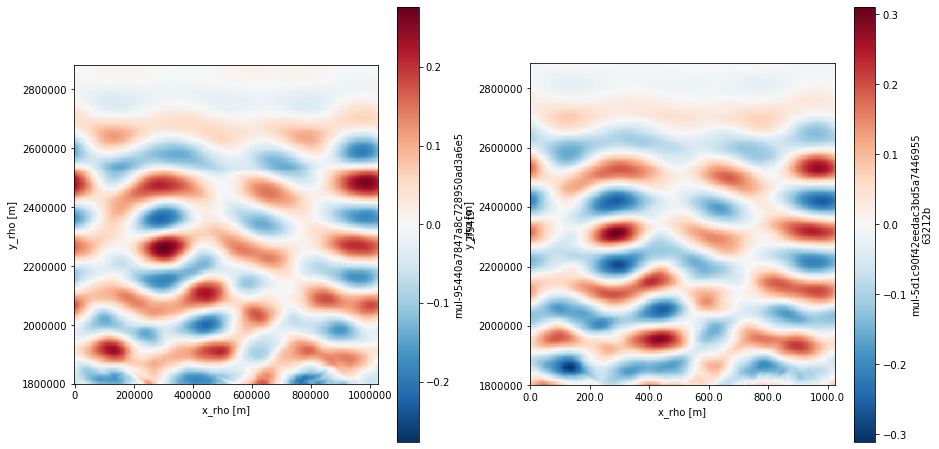

In [11]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
vtst.sel(y_rho=slice(1800*1e3,None)).plot(ax=ax[1]);ax[1].set_aspect('equal')
utst.sel(y_rho=slice(1800*1e3,None)).plot(ax=ax[0]);ax[0].set_aspect('equal')
ax[1].set_xlim(0,1024*1e3)
lab = ax[1].get_xticks()
lab = [str(l*1e-3) for l in lab]
ax[1].set_xticklabels(lab)

In [29]:
vtsti = vtst.sel(y_rho=slice(1800*1e3,None))
utsti = utst.sel(y_rho=slice(1800*1e3,None))
Utsti = 0.5*np.sqrt(vtsti**2+utsti**2)

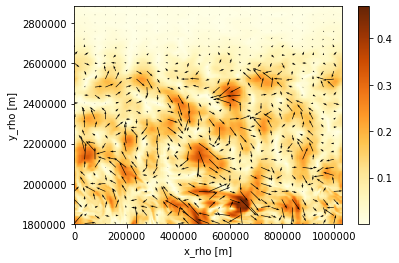

In [47]:
Utsti.plot(cmap='YlOrBr')
plt.quiver(utsti.x_rho[::10],utsti.y_rho[::10],utsti[::10,::10],vtsti[::10,::10])

In [9]:
v = ds['v'].compute()
u = ds['u'].compute()

In [55]:
v.time.diff('time')*(24*3600)

<xarray.DataArray 'time' (time: 11999)>
array([3600.        , 3600.        , 3600.        , ..., 3600.        ,
       3600.00000001, 3600.        ])
Coordinates:
  * time     (time) float64 500.1 500.1 500.1 500.2 ... 999.9 999.9 999.9 1e+03

In [10]:
maps = ['RdBu_r','RdBu_r','YlOrBr']

def gen_figs(t,y0,y1,dxy,figsize,savefig=False,name=None):
    vi = x2rho(v.isel(time=t),r.xgrid,'extrapolate').sel(y_rho=slice(y0*1e3,y1*1e3))
    ui = x2rho(u.isel(time=t),r.xgrid,'extrapolate').sel(y_rho=slice(y0*1e3,y1*1e3))
    U = 0.5*np.sqrt(vi**2+ui**2)
    levs = [np.linspace(-0.5,0.5),np.linspace(-0.5,0.5),np.linspace(0.,0.5)]
    fig,ax = plt.subplots(1,3,figsize=figsize)
    for V, axs,cmap,names,lev in zip([ui,vi,U],ax,maps,['u','v',r'$\frac{1}{2}\sqrt{u^2+v^2}$'],levs):
        V.plot(ax=axs,cmap=cmap,levels=lev);axs.set_title(names)
        axs.set_xlim(0,1024*1e3);axs.set_ylim(y0*1e3,y1*1e3)
        labx,laby = axs.get_xticks(),axs.get_yticks();labx,laby = [str(l*1e-3) for l in labx],[str(l*1e-3) for l in laby];
        axs.set_xticklabels(labx);axs.set_yticklabels(laby)
        axs.set_aspect('equal');axs.set_ylabel(r'$y_\rho$(km)');axs.set_xlabel(r'$x_\rho$(km)')
    ax[2].quiver(ui.x_rho[::dxy],ui.y_rho[::dxy],ui[::dxy,::dxy],vi[::dxy,::dxy])
    fig.suptitle('t = %s days'%np.around(v.isel(time=t).time.values,decimals=3),x=0.5,y=1,fontsize=15)
    fig.tight_layout()
    if savefig:
        fig.savefig('/home1/datawork/zcaspar/Figs/'+name,overwrite=True)
        plt.close()
def gen_figs_u6(t,y0,y1,dxy,figsize,savefig=False,name=None):
    vi = x2rho(v.isel(time=t),r.xgrid,'extrapolate').sel(y_rho=slice(y0*1e3,y1*1e3))
    ui = x2rho(u.isel(time=t),r.xgrid,'extrapolate').sel(y_rho=slice(y0*1e3,y1*1e3))
    U = 0.5*np.sqrt(vi**2+ui**2)
    vi6 = x2rho(v.isel(time=t+6),r.xgrid,'extrapolate').sel(y_rho=slice(y0*1e3,y1*1e3))
    ui6 = x2rho(u.isel(time=t+6),r.xgrid,'extrapolate').sel(y_rho=slice(y0*1e3,y1*1e3))
    U6 = 0.5*np.sqrt(vi6**2+ui6**2)
    levs = [np.linspace(-0.5,0.5),np.linspace(-0.5,0.5),np.linspace(0.,0.5)]
    fig,ax = plt.subplots(1,3,figsize=figsize)
    for V, axs,cmap,names,lev in zip([(ui+ui6)/2,(vi+vi6)/2,(U+U6)/2],ax,maps,['u','v',r'$\frac{1}{2}\sqrt{u^2+v^2}$'],levs):
        V.plot(ax=axs,cmap=cmap,levels=lev);axs.set_title(names)
        axs.set_xlim(0,1024*1e3);axs.set_ylim(y0*1e3,y1*1e3)
        labx,laby = axs.get_xticks(),axs.get_yticks();labx,laby = [str(l*1e-3) for l in labx],[str(l*1e-3) for l in laby];
        axs.set_xticklabels(labx);axs.set_yticklabels(laby)
        axs.set_aspect('equal');axs.set_ylabel(r'$y_\rho$(km)');axs.set_xlabel(r'$x_\rho$(km)')
    ax[2].quiver(ui.x_rho[::dxy],ui6.y_rho[::dxy],ui[::dxy,::dxy],vi6[::dxy,::dxy])
    fig.suptitle('t = %s days'%np.around(v.isel(time=t).time.values,decimals=3),x=0.5,y=1,fontsize=15)
    fig.tight_layout()
    if savefig:
        fig.savefig('/home1/datawork/zcaspar/Figs/'+name,overwrite=True)
        plt.close()

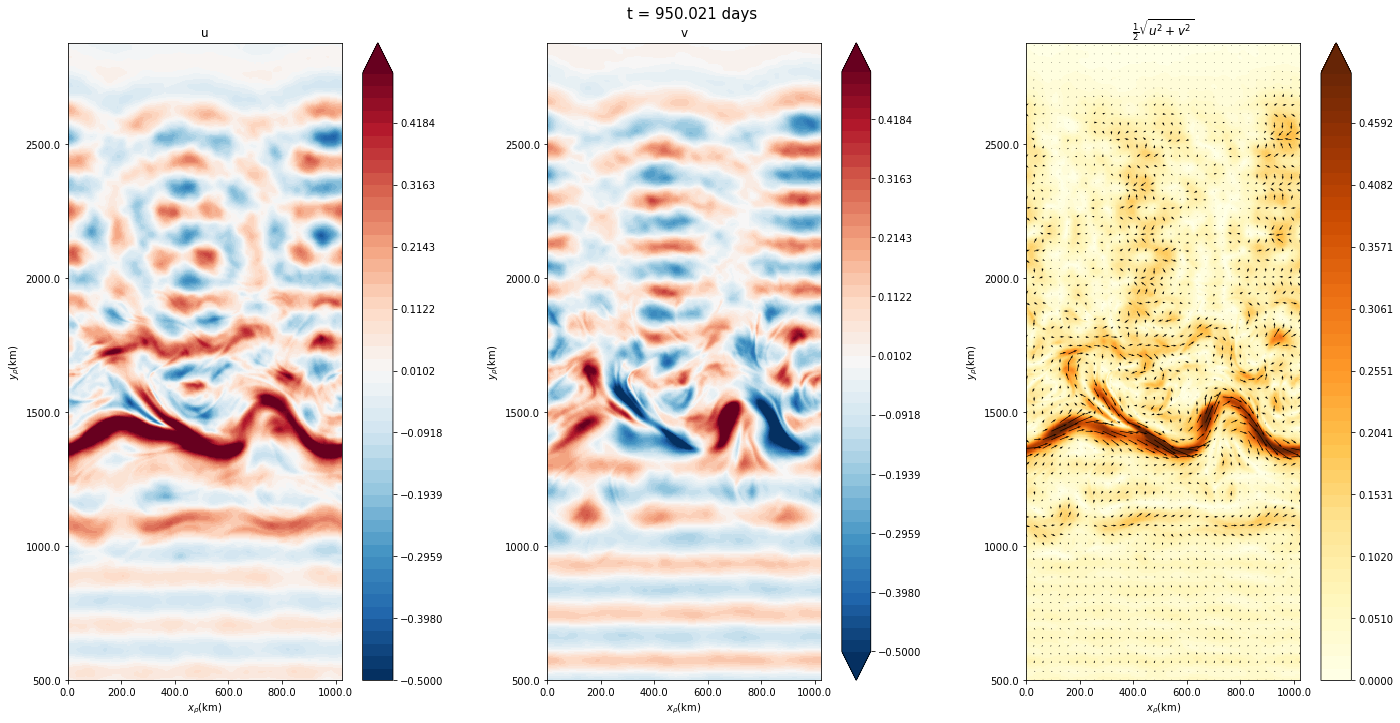

In [11]:
gen_figs(450*24,500,2880,8,(20,10),savefig=False,name='test.png')

In [13]:
for t in range(0,v.time.size,24):
    n='Eulerian/t%s'%t
    gen_figs_u6(t,500,2880,8,(20,10),savefig=True,name=n+'.png')

In [11]:
dr = cdr.drifter_dataframe(root_path+run,parquet=True,index='id',persist=False)
dr

         time      xgrid      ygrid  zgrid     depth       temp         u  \
id                                                                          
1   600.00000  21.528084  145.18074   50.0  0.413050  24.582007 -0.035198   
1   501.95833  12.907306  150.21213   50.0  0.389337  24.579460 -0.007694   
1   732.68056  25.852016  148.62693   50.0  0.392834  24.583186  0.062496   
1   501.95139  12.908477  150.21330   50.0  0.389176  24.579460 -0.007674   
1   501.94444  12.909642  150.21456   50.0  0.389022  24.579461 -0.007621   

           v          dudt      dvdt      pres           x          y  
id                                                                     
1   0.127379  1.209813e-05  0.000007  4.927189   86.112336  580.72296  
1  -0.007056 -1.898434e-08  0.000001  4.694459   51.629224  600.84852  
1   0.006931  2.277491e-06 -0.000015  4.728906  103.408064  594.50772  
1  -0.007708 -7.522094e-08  0.000001  4.692880   51.633908  600.85320  
1  -0.008341 -1.293721e-07  

In [16]:
df0 = dr.df[dr.df.time==dr.df.time.min()]

In [21]:
y0 = df0.y.compute()

In [12]:
df1 = dr.df[dr.df.time==dr.df.time.max()]
y1 = df1.y.compute()

In [13]:
ids = y1.index

In [14]:
tst = dr.df.loc[list(ids[0::80])]

In [15]:
ids[0::80]

Int64Index([   1,   81,  161,  241,  322,  402,  482,  564,  647,  728,
            ...
            7642, 7726, 7806, 7886, 7969, 8050, 8130, 8212, 8299, 8379],
           dtype='int64', name='id', length=103)

In [23]:
x,y = tst.x.compute(),tst.y.compute()

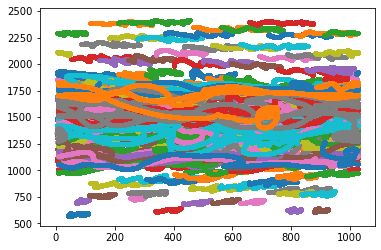

In [46]:
var.max()

<xarray.DataArray ()>
array(0.12845677, dtype=float32)

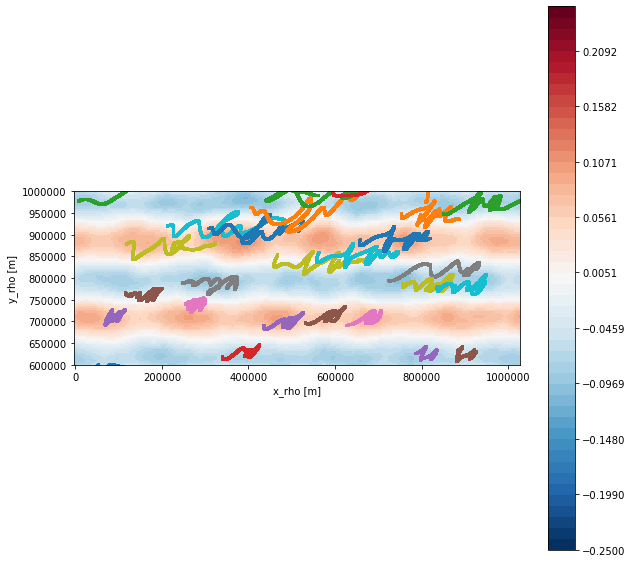

In [54]:
cmap = 'RdBu_r'
levs = np.linspace(-0.25,0.25)
#var = np.sqrt(x2rho(u,r.xgrid,'extrapolate').sel(y_rho=slice(600*1e3,1100*1e3))**2+x2rho(ds['v'].compute(),r.xgrid,'extrapolate').sel(y_rho=slice(600*1e3,1100*1e3))**2).mean(dim='time')
fig, ax = plt.subplots(figsize=(10,10))
x2rho(u.isel(time=6000),r.xgrid,'extrapolate').sel(y_rho=slice(600*1e3,1000*1e3)).plot(ax=ax,cmap=cmap,levels=levs)
ax.set_ylim(600*1e3,1000*1e3)
ax.set_aspect('equal')
for ids in x.index.unique():
    ax.scatter(x.loc[ids]*1e3,y.loc[ids]*1e3,s=4)

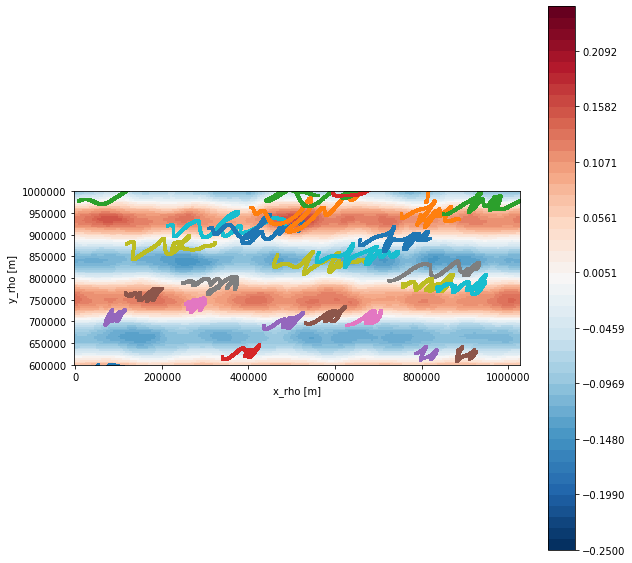

In [55]:
fig, ax = plt.subplots(figsize=(10,10))
x2rho(ds['v'].compute().isel(time=6000),r.xgrid,'extrapolate').sel(y_rho=slice(600*1e3,1000*1e3)).plot(ax=ax,cmap=cmap,levels=levs)
ax.set_ylim(600*1e3,1000*1e3)
ax.set_aspect('equal')
for ids in x.index.unique():
    ax.scatter(x.loc[ids]*1e3,y.loc[ids]*1e3,s=4)

In [ ]:
# df = tst.set_index('time').persist()

In [18]:
t0 = df.loc[750].compute()

In [77]:
time = df.index.values.compute()

In [78]:
time = np.unique(time)
time.size

72000

In [64]:
t = 450*24
dfi = df.loc[time[t*6]].compute()

In [65]:
df.loc[600].compute()

,xgrid,ygrid,zgrid,depth,temp,u,v,dudt,dvdt,pres,x,y
time,,,,,,,,,,,,
600.0,205.938030,227.97980,50.0,0.589360,24.589381,-0.031392,0.061273,0.000012,-0.000007,6.657117,823.752120,911.91920
600.0,246.104480,261.54929,50.0,0.488059,24.588071,0.010084,-0.245536,-0.000006,-0.000008,5.663272,984.417920,1046.19716
600.0,60.024845,267.05118,50.0,0.557856,24.598596,0.165963,0.169635,0.000002,-0.000023,6.348364,240.099380,1068.20472
600.0,160.129640,397.98013,50.0,-0.186687,24.946739,0.703765,0.030451,-0.000003,-0.000009,-0.943946,640.518560,1591.92052
600.0,214.543760,418.57906,50.0,-0.249174,25.120293,-0.123868,0.163815,0.000002,0.000031,-1.550772,858.175040,1674.31624
...,...,...,...,...,...,...,...,...,...,...,...,...
600.0,217.326570,297.32833,50.0,0.433506,24.666356,0.180988,0.082109,-0.000007,0.000014,5.130826,869.306280,1189.31332
600.0,129.443780,326.08147,50.0,0.360344,24.748667,0.193595,0.201318,0.000014,0.000013,4.415938,517.775120,1304.32588
600.0,137.005510,264.53853,50.0,0.491014,24.664026,0.241774,-0.083730,-0.000008,-0.000019,5.694949,548.022040,1058.15412


In [38]:
u.isel(time=24).time.values

array(501.02083333)

In [41]:
df.loc[time[24*6+2]]

,id,xgrid,ygrid,zgrid,depth,temp,u,v,dudt,dvdt,pres,x,y
npartitions=1,,,,,,,,,,,,,
501.02083,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
501.02083,...,...,...,...,...,...,...,...,...,...,...,...,...


In [52]:
dfi.index.unique().values[0]


960.00694

In [21]:
time

array([ 500.00694,  500.00694,  500.00694, ..., 1000.     , 1000.     ,
       1000.     ])

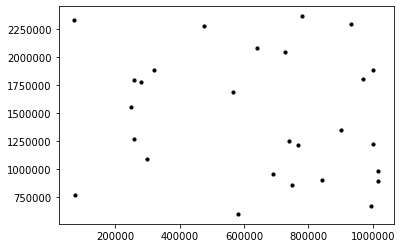

In [21]:
t = 460*24
dfi = df.loc[time[t*6]].compute()
plt.scatter(dfi.x[::4]*1e3,dfi.y[::4]*1e3,s=10,c='k')

In [33]:
vari = x2rho(u.isel(time=t),r.xgrid,'extrapolate')#.sel(y_rho=slice(500*1e3,2800*1e3))

In [83]:
ti = u.isel(time=t)

In [99]:
list(ti.time.values.reshape(1,1)[0])

[960.0208333333333]

In [100]:
df.loc[list(ti.time.values.reshape(1,1)[0])]

,xgrid,ygrid,zgrid,depth,temp,u,v,dudt,dvdt,pres,x,y
npartitions=1,,,,,,,,,,,,
960.020833,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
960.020833,...,...,...,...,...,...,...,...,...,...,...,...


In [85]:
maps = ['RdBu_r','RdBu_r','YlOrBr']

def gen_figs(t,y0,y1,dxy,df,figsize,savefig=False,name=None):
    cmap=maps[0]
    vari = x2rho(u.isel(time=t),r.xgrid,'extrapolate').sel(y_rho=slice(y0*1e3,y1*1e3))
    dfi = df.loc[time[t*6+2]].compute()
    levs = np.linspace(-0.25,0.25)#,np.linspace(-0.5,0.5),np.linspace(0.,0.5)]
    fig,ax = plt.subplots(figsize=figsize)
    vari.plot(ax=ax,cmap=cmap,levels=levs)
    ax.scatter(dfi.x*1e3,dfi.y*1e3,s=12,c='k')
    ax.set_xlim(0,1024*1e3);ax.set_ylim(y0*1e3,y1*1e3)
    labx,laby = ax.get_xticks(),ax.get_yticks();labx,laby = [str(l*1e-3) for l in labx],[str(l*1e-3) for l in laby];
    ax.set_xticklabels(labx);ax.set_yticklabels(laby)
    ax.set_aspect('equal');ax.set_ylabel(r'$y_\rho$(km)');ax.set_xlabel(r'$x_\rho$(km)')
    ax.set_title('t = %s days'%np.around(dfi.index.unique().values[0],decimals=3),x=0.5,y=1,fontsize=15)#u.isel(time=t).time.values
    fig.tight_layout()
    if savefig:
        fig.savefig('/home1/datawork/zcaspar/Figs/'+name,overwrite=True)
        plt.close()
    return dfi

In [144]:
print(time[t*6+2])
u.isel(time=t).time

960.02083


<xarray.DataArray 'time' ()>
array(960.02083333)
Coordinates:
    time_instant  float64 960.0
    time          float64 960.0
    s_rho_slice0  float32 -0.01
Attributes:
    units:          m
    standard_name:  time_counter
    long_name:      time_counter

In [31]:
vari

<xarray.DataArray 'mul-2561c984f8a9b5ca7c86c401fbdfafd0' (y_rho: 722, x_rho: 258)>
array([[ 0.00588124,  0.00588096,  0.00587907, ...,  0.00590509,
         0.00588775,  0.00587445],
       [ 0.00537668,  0.00537535,  0.00537291, ...,  0.00540158,
         0.00538309,  0.00536895],
       [ 0.00473753,  0.00473469,  0.00473121, ...,  0.00475997,
         0.00474267,  0.00472956],
       ...,
       [-0.009857  , -0.00960338, -0.00937516, ..., -0.01019883,
        -0.00988053, -0.00957985],
       [-0.00902211, -0.0087685 , -0.00854031, ..., -0.00938846,
        -0.00905155, -0.00873906],
       [-0.0081749 , -0.0079162 , -0.00768476, ..., -0.00857527,
        -0.00821011, -0.00788099]], dtype=float32)
Coordinates:
  * y_rho    (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
  * x_rho    (x_rho) float32 -2000.0 2000.0 6000.0 ... 1022000.0 1026000.0

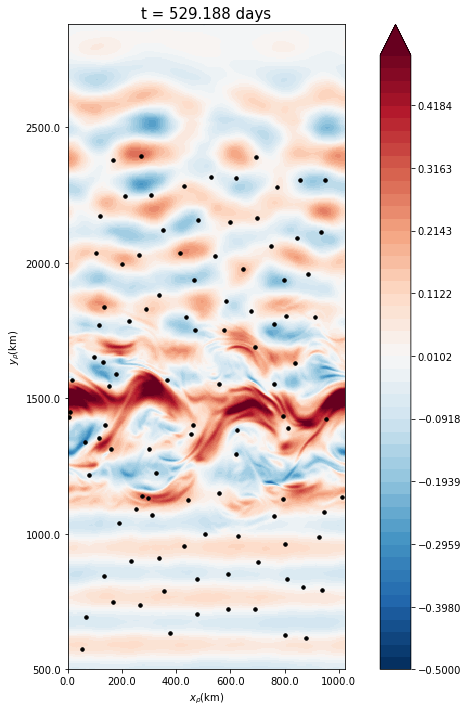

In [81]:
tst = gen_figs(700,500,2880,4,df,(10,10),savefig=False,name='test.png')


In [86]:
for t in range(0,u.time.size,12):
    n='Floats/t%s'%t
    gen_figs(t,500,1200,8,df,(10,10),savefig=True,name=n+'.png')

In [60]:
df0 = dr.df.reset_index()
df0 = df0.set_index('y').persist()

In [58]:
y0 = df0.loc[500+10/24/6].y.compute()

In [ ]:
df0.time.values.compute()

In [41]:
def gen_fig_flts(t,y0,y1,dxy,figsize,savefig=False,name=None):
#    vi = x2rho(v.isel(time=t),r.xgrid,'extrapolate').sel(y_rho=slice(y0*1e3,y1*1e3))
    ui = x2rho(u.isel(time=t),r.xgrid,'extrapolate').sel(y_rho=slice(y0*1e3,y1*1e3))
#    U = 0.5*np.sqrt(vi**2+ui**2)
    levs = np.linspace(-0.5,0.5)#[np.linspace(-0.5,0.5),np.linspace(-0.5,0.5),np.linspace(0.,0.5)]
    fig,ax = plt.subplots(figsize=figsize)
    #for V, axs,cmap,names,lev in zip([ui,vi,U],ax,maps,['u','v',r'$\frac{1}{2}\sqrt{u^2+v^2}$'],levs):
    ui.plot(ax=ax,cmap=cmap,levels=levs);ax.set_title('u')
    ax.set_xlim(0,1024*1e3);ax.set_ylim(y0*1e3,y1*1e3)
    labx,laby = axs.get_xticks(),ax.get_yticks();labx,laby = [str(l*1e-3) for l in labx],[str(l*1e-3) for l in laby];
    ax.set_xticklabels(labx);ax.set_yticklabels(laby)
    ax.set_aspect('equal');ax.set_ylabel(r'$y_\rho$(km)');ax.set_xlabel(r'$x_\rho$(km)')
    #ax[2].quiver(ui.x_rho[::dxy],ui.y_rho[::dxy],ui[::dxy,::dxy],vi[::dxy,::dxy])
    ax.set_title('t = %s days'%np.around(v.isel(time=t).time.values,decimals=3),x=0.5,y=1,fontsize=15)
    fig.tight_layout()
    if savefig:
        fig.savefig('/home1/datawork/zcaspar/Figs/'+name,overwrite=True)
        plt.close()

In [13]:
maps = ['RdBu_r','RdBu_r','YlOrBr']

def gen_figs(t):
    vi = x2rho(v.isel(time=t),r.xgrid,'extrapolate').sel(y_rho=slice(1800*1e3,2880*1e3))
    ui = x2rho(u.isel(time=t),r.xgrid,'extrapolate').sel(y_rho=slice(1800*1e3,2880*1e3))
    U = 0.5*np.sqrt(vi**2+ui**2)
    vmins = [-0.6,-0.6,0]
    vmaxs = [0.6,0.6,0.6]
   # fig,ax = plt.subplots(1,3,figsize=figsize)
    for V, axs,cmap,names,vmin,vmax in zip([ui,vi,U],ax,maps,['u','v',r'$\frac{1}{2}\sqrt{u^2+v^2}$'],vmins,vmaxs):
        
        V.plot(ax=axs,cmap=cmap,vmin=vmin,vmax=vmax,add_colorbar=False)
        #,cbar_kwargs={'label':names}
        axs.set_title(names+' : vmin = %s and vmax = %s'%(vmin,vmax))
    ax[2].quiver(ui.x_rho[::8],ui.y_rho[::8],ui[::8,::8],vi[::8,::8])
    fig.suptitle('t = %s days'%np.around(v.isel(time=t).time.values,decimals=3),x=0.5,y=1,fontsize=15)
    #fig.tight_layout()


MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


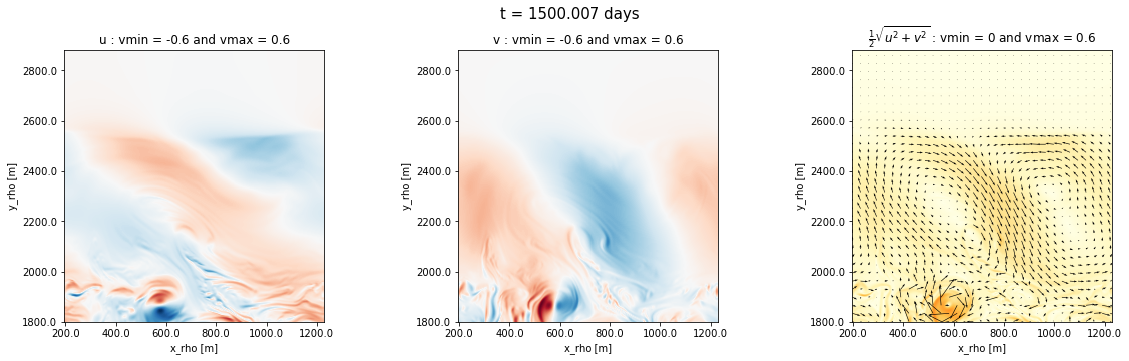

In [14]:
fig,ax = plt.subplots(1,3,figsize=(20,5))
#ax.set(xlim=(0, 1024*), ylim=(0, 10))

#contour_opts = {'levels': np.linspace(0, 1, 10),
#                'cmap':'RdBu'}
from matplotlib.animation import FuncAnimation
cax = gen_figs(0)

for axs in ax:
    axs.set_xlim(0,1024*1e3);axs.set_ylim(1800*1e3,2880*1e3)
    labx,laby = axs.get_xticks(),axs.get_yticks();labx,laby = [str(l*1e-3) for l in labx],[str(l*1e-3) for l in laby];
    axs.set_xticklabels(labx);axs.set_yticklabels(laby)
    axs.set_aspect('equal');axs.set_ylabel(r'$y_\rho$(km)');axs.set_xlabel(r'$x_\rho$(km)')
def animate(i):
    ax[0].collections = []
    ax[1].collections = []
    ax[2].collections = []
    gen_figs(i)
    
anim = FuncAnimation(fig,gen_figs,frames=v.time.size)
anim.save('/home1/datawork/zcaspar/tst.gif', writer = 'imagemagick')
plt.draw()
plt.show()

In [17]:
def gen_fig(t,y0,y1,dxy,figsize,savefig=False,name=None):
    vi = x2rho(v.isel(time=t),r.xgrid,'extrapolate').sel(y_rho=slice(y0*1e3,y1*1e3))
    ui = x2rho(u.isel(time=t),r.xgrid,'extrapolate').sel(y_rho=slice(y0*1e3,y1*1e3))
    U = 0.5*np.sqrt(vi**2+ui**2)
    fig,ax = plt.subplots(figsize=figsize)
    U.plot(ax=ax,cmap='YlOrBr',vmin=0,vmax=0.5,cbar_kwargs={'label':r'$\frac{1}{2}\sqrt{u^2+v^2}$'})
    ax.set_aspect('equal');ax.set_ylabel(r'$y_\rho$(m)');ax.set_xlabel(r'$x_\rho$(m)')
    ax.quiver(ui.x_rho[::dxy],ui.y_rho[::dxy],ui[::dxy,::dxy],vi[::dxy,::dxy])
    plt.title('t = %s days'%np.around(v.isel(time=t).time.values,decimals=2))
    fig.tight_layout()
    if savefig:
        fig.savefig('/home1/datawork/zcaspar/Figs/North_uv/'+name,overwrite=True)
        plt.close()

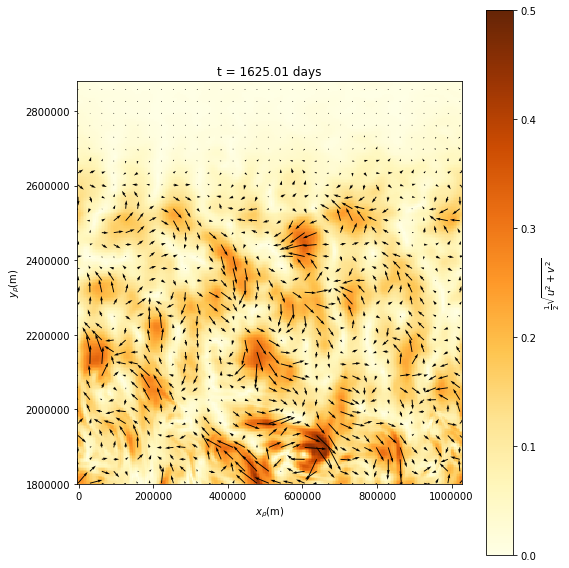

In [48]:
gen_fig(500,1800,2880,8,(8,8))

In [24]:
for t in range(v.isel(time=slice(0,200*24)).time.size):
    n='t%s'%t
    gen_fig(t,1800,2880,8,(7,7),savefig=True,name=n+'.png')

NameError: name 'gen_fig' is not defined

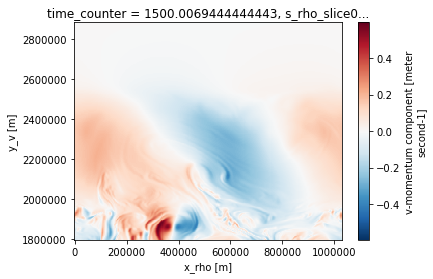

In [14]:
import matplotlib.animation as animation

fig = plt.figure() # initialise la figure
im = v.isel(time=0).sel(y_v=slice(1800*1e3,None)).plot(animated=True)
#plt.xlim(xmin, xmax)
#plt.ylim(-1,1)
i=0
def updatefig(*args):
   # global i
    for i in range(v.isel(time=slice(0,2)).time.size):
        im.set_array(v.isel(time=i).sel(y_v=slice(1800*1e3,None)).values)
    return im,
    #plt.pause(0.01)
#ani = animation.FuncAnimation(fig, updatefig,  blit=True)

# fonction à définir quand blit=True
# crée l'arrière de l'animation qui sera présent sur chaque image
def init():
    line.set_data([],[])
    return line,

def animate(i): 
    t = i * dt
    y = np.cos(k*x - w*t)
    line.set_data(x, y)
    return line,
plt.show()
#ani = animation.FuncAnimation(fig, animate, init_func=init, frames=100, blit=True, interval=20, repeat=False)

In [13]:
v.isel(time=i).sel(y_v=slice(1800*1e3,None)).values


array([[-0.137887  , -0.13408142, -0.12118018, ..., -0.13308674,
        -0.137887  , -0.13408142],
       [-0.13515852, -0.12665081, -0.1098358 , ..., -0.13450676,
        -0.13515852, -0.12665081],
       [-0.12659895, -0.11390333, -0.09583312, ..., -0.1308356 ,
        -0.12659895, -0.11390333],
       ...,
       [ 0.00152088,  0.0015115 ,  0.00149654, ...,  0.00152515,
         0.00152088,  0.0015115 ],
       [ 0.00146048,  0.00145136,  0.00143341, ...,  0.00146307,
         0.00146048,  0.00145136],
       [ 0.00140181,  0.00139375,  0.00137469, ...,  0.00140207,
         0.00140181,  0.00139375]], dtype=float32)

In [24]:
fig = plt.figure() # initialise la figure
im = v.isel(time=0).sel(y_v=slice(1800*1e3,None)).plot(animated=True)
im.set_array(v.isel(time=1).sel(y_v=slice(1800*1e3,None)))
plt.show()

ValueError: Collections can only map rank 1 arrays

<Figure size 432x288 with 2 Axes>

In [19]:
im.set_animated(True)

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


ValueError: unknown file extension: .mp4

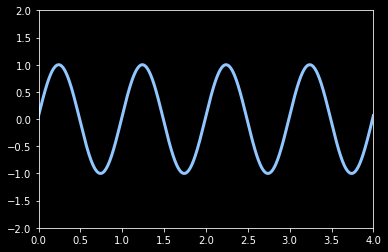

In [30]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')


fig = plt.figure()
ax = plt.axes(xlim=(0, 4), ylim=(-2, 2))
line, = ax.plot([], [], lw=3)

def init():
    line.set_data([], [])
    return line,
def animate(i):
    x = np.linspace(0, 4, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

anim.save('/home1/datawork/zcaspar/sine_wave.mp4', writer='ffmpeg')

In [33]:
import numpy as np
from matplotlib import pyplot as plt
from celluloid import Camera

fig, axes = plt.subplots(2)
camera = Camera(fig)
t = np.linspace(0, 2 * np.pi, 128, endpoint=False)
for i in t:
    axes[0].plot(t, np.sin(t + i), color='blue')
    axes[1].plot(t, np.sin(t - i), color='blue')
    camera.snap()
    
animation = camera.animate() 

ModuleNotFoundError: No module named 'celluloid'

In [39]:
cluster.scale(jobs=2)

In [41]:
client.restart()

distributed.scheduler - ERROR - Not all workers responded positively: ['OK', 'OK', 'OK', 'OK', 'OK', 'OK', 'OK', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out']
NoneType: None


Client Scheduler: tcp://10.148.0.53:33779 Dashboard: http://10.148.0.53:8787/status,Cluster Workers: 14 Cores: 14 Memory: 239.96 GB


In [56]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
